In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from src.classifier_functions import *

import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline 

### Reading in the Data 

In [2]:
data = pd.read_csv('../users_final.csv')

In [32]:
final = pd.read_csv('../users_test.csv')

### Setting Up the Model 

In [38]:
y = data['target'].values
X = data.iloc[:,:-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y)


rfc = RandomForestClassifier(n_estimators= 1000,
                         min_samples_split= 10,
                         min_samples_leaf= 2,
                         max_features= 'auto',
                         max_depth= 6,
                         )
rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
y_hat = rfc.predict(X_test)

In [42]:
y_train_hat = rfc.predict(X_train)

### Dev Test Scores 

In [54]:
scorecard(rfc, X_test, y_test, y_hat)


The Accuracy score is 0.860.
The Precision score is 0.771.
The Recall score is 0.554.
      Confusion Matrix


,Actual True,Actual False
Predicted True,759,225
Predicted False,610,4368


### Train Confusion Matrix and Scores 

In [44]:
scorecard(rfc, X_train, y_train, y_train_hat)

The Accuracy score is 0.853.
The Precision score is 0.757.
The Recall score is 0.541.
    Confusion Matrix


,Actual True,Actual False
Predicted True,2253,724
Predicted False,1909,13000


### Final Test with Confusion Matrix and Stats

In [47]:
y_final = final['target'].values
X_final = final.iloc[:,:-1].values
y_final_hat = rfc.predict(X_final)

In [48]:
scorecard(rfc, X_final, y_final, y_final_hat)

The Accuracy score is 0.694.
The Precision score is 0.822.
The Recall score is 0.743.
    Confusion Matrix


,Actual True,Actual False
Predicted True,3805,822
Predicted False,1318,1049


### Plotting the ROC Curve 


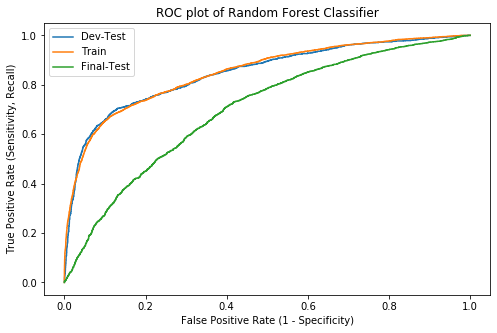

In [49]:
probabilities = rfc.predict_proba(X_test)[:, 1]
probabilities2 = rfc.predict_proba(X_train)[:, 1]
probabilitiesf= rfc.predict_proba(X_final)[:, 1]

tpr, fpr, thresholds = roc_curve_(probabilities, y_test)
tpr2, fpr2, thresholds2 = roc_curve_(probabilities2, y_train)
tprf, fprf, thresholdsf = roc_curve_(probabilitiesf, y_final)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr, label='Dev-Test')
ax.plot(fpr2, tpr2, label='Train')
ax.plot(fprf, tprf, label='Final-Test')
ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity, Recall)")
ax.set_title("ROC plot of Random Forest Classifier")
ax.legend()
plt.show()

### Looking at Feature Importances 

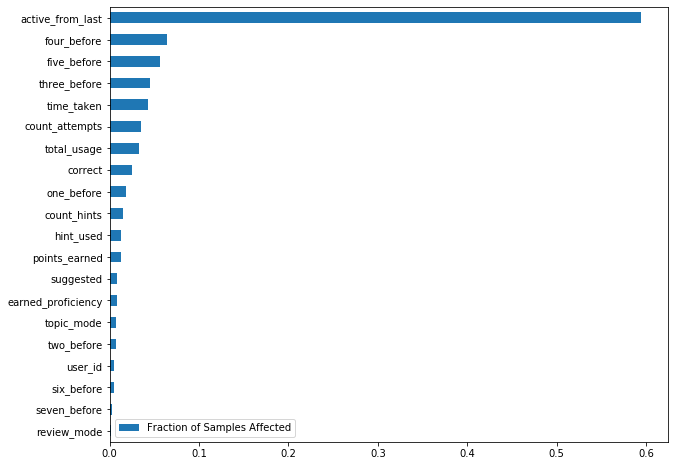

In [50]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rfc.feature_importances_},
                           index=data.columns.values[:-1])
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(10,8))

### Randomized Grid Seach Results

In [79]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model


In [92]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3,8,5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = True
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 8, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': True}


In [94]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 53.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [95]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}